In [1]:
using Plots
using LinearAlgebra
using Random
using JLD
using StatsPlots
using ProgressMeter
include("/home/javier/Desktop/alpcahus/alpcahus.jl")
include("/home/javier/Desktop/alpcahus/cluster.jl")
include("/home/javier/Desktop/alpcahus/otherMethods.jl")
include("/home/javier/Desktop/alpcahus/adssc.jl")

lsr (generic function with 1 method)

In [2]:
Y1, v1full = load("astroData_z2.jld","Yfull", "vfull") # z2_bal
Y2, v2full = load("astroData_z1.jld", "Yfull", "vfull");
tmp = randperm(MersenneTwister(4321), size(Y2)[2])[1:2500]
Y2 = Y2[:,tmp];
v2full = v2full[tmp];
tmp = randperm(MersenneTwister(4321), size(Y1)[2])[1:2500]
Y1 = Y1[51:281-50,tmp];
v1full = v1full[tmp]
K = 2;
Y1test = Y1[:,1:2500]
Y2test = Y2[:,1:2500];

In [3]:
# params
params = load("params2.jld", "params");

In [4]:
Utrue = []
push!(Utrue,fastALPCAH(Y1test[:,1:1000],params["rank"]; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
push!(Utrue,fastALPCAH(Y2test[:,1:1000],params["rank"]; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
nothing;

In [5]:
methodsList = ["Noisy Oracle" "EKSS" "ALPCAHUS" "EKSS (B=1)" "ALPCAHUS (B=1)" "ADSSC" "TSC" "K-means"]
num_methods = length(methodsList)
num_trials = 100; ntest = 200 

200

In [6]:
test_errors = zeros(num_methods,1,num_trials)
p = Progress(num_trials; dt=1)
for trial=1:num_trials
    shuffleIndex1 = shuffle(1:size(Y1test)[2])[1:ntest]
    shuffleIndex2 = shuffle(1:size(Y2test)[2])[1:ntest]
    shuffleIndex3 = shuffle(1:size(Y1test)[2])[1:ntest]
    shuffleIndex4 = shuffle(1:size(Y2test)[2])[1:ntest]
    
    
    test1 = @view Y1test[:,shuffleIndex1]
    test2 = @view Y2test[:,shuffleIndex2]
    #train1 = @view Y1train[:,shuffleIndex3]
    #train2 = @view Y2train[:,shuffleIndex4]
    Ytest = hcat(test1,test2)
    #Ytrain = hcat(train1,train2)
    C = vcat(1*ones(Int, ntest), 2*ones(Int, ntest))

    # METHODS
    # Noisy Oracle
    U = []
    for k=1:K
        push!(U,fastALPCAH(Ytest[:,C .== k], params["rank"]; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
    end
    C_oracle = clusterAssignment(Ytest, U, K);
    oracleError = clusterError(C,C_oracle)
    # ekss trial
    C_ekss = ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=64, q=params["ekss"], T=3, subspaceMethod=:pca, finalStep=false)
    ekssError = clusterError(C,C_ekss)
    # alpcahus trail
    C_alpcahus = ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=64, q=params["alpcahus"], T=3, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true) 
    alpcahusError = clusterError(C,C_alpcahus)
    # ekss smart init trial
    C_kss = ALPCAHUS(Ytest, K, [params["rank"];params["rank"]]; B=1, q=params["ekss"], T=100, subspaceMethod=:pca, finalStep=false, spectralStart=true)
    kssError = clusterError(C, C_kss)
    # alpcahus smart init trail
    C_alpcah = ALPCAHUS(Ytest,K, [params["rank"];params["rank"]]; B=1, q=params["alpcahus"], T=100, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true, spectralStart=true) 
    alpcahError = clusterError(C, C_alpcah)
    # adssc
    C_adssc = adsscWrapper(Ytest, params["adssc"][1], params["adssc"][2]; K=2)
    adsscError = clusterError(C,C_adssc)
    # tsc
    C_tsc = tscWrapper(Ytest, params["tsc"]; K=2)
    tscError = clusterError(C,C_tsc)
    # kmeans
    C_kmeans = kmeans(Elkan(), Ytest, 2; k_init="k-means++").assignments
    kmeansError = clusterError(C,C_kmeans)

    # save results
    test_errors[1,1,trial] = oracleError
    test_errors[2,1,trial] = ekssError
    test_errors[3,1,trial] = alpcahusError
    test_errors[4,1,trial] = kssError
    test_errors[5,1,trial] = alpcahError
    test_errors[6,1,trial] = adsscError
    test_errors[7,1,trial] = tscError
    test_errors[8,1,trial] = kmeansError
    
    next!(p)
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:18:14


In [7]:
save("trialData2.jld", "test_errors", test_errors);

In [7]:
test_errors = load("trialData2.jld", "test_errors");

In [8]:
colors = palette(:default)

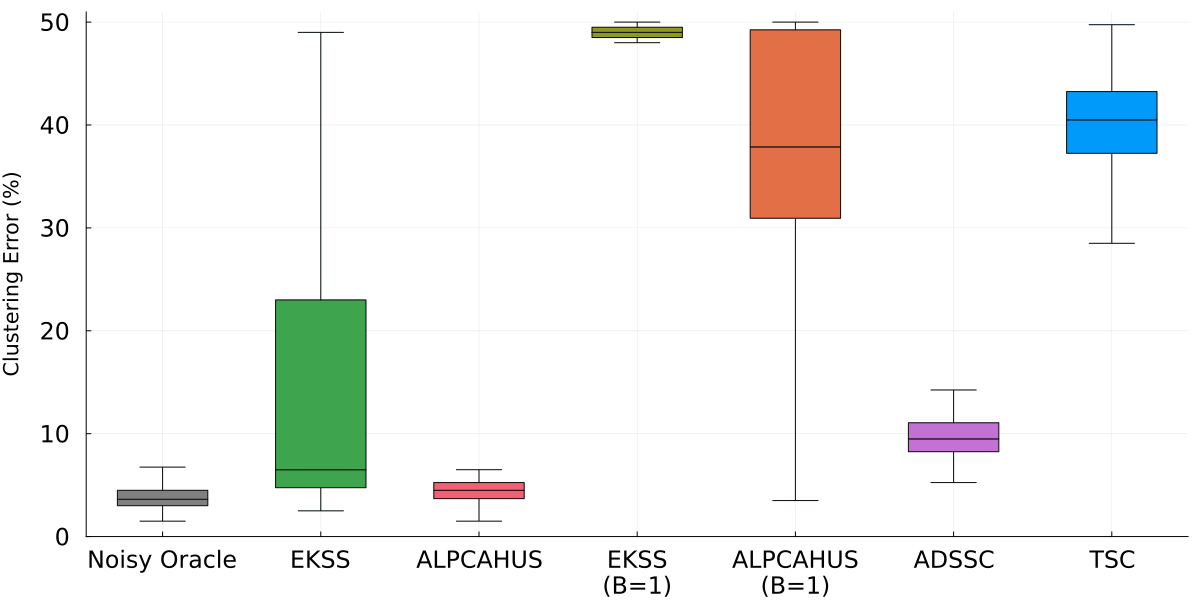

In [9]:
boxplots = []
titles = [""]
methodsList = ["Noisy Oracle" "EKSS" "ALPCAHUS" " EKSS \n(B=1)" " ALPCAHUS \n(B=1)" "ADSSC" "TSC"]
#p = plot(size=(300,300))
p = boxplot(methodsList, test_errors[1:end-1,1,:]', leg = false,title=titles[1],color=[:gray colors[3] colors[end-2] colors[10] colors[2] colors[4] colors[1]],ylabel="Clustering Error (%)", outliers=false)
push!(boxplots,p)  

using Plots.PlotMeasures
# size=(2100,300)
plot_boxes = plot(boxplots..., size=(1200,600),
                    left_margin = 5mm,
                    bottom_margin = 5mm,
                    legendfontpointsize=14,xtickfontsize=16,ytickfontsize=16,guidefontsize=14,titlefontsize=14,
                    ylim = (0,51)
                    )
#savefig("clustering_results.svg")